## Transfer Learning

In [1]:
import tensorflow as tf
print(tf.__version__)

2023-12-02 15:06:12.322953: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-02 15:06:13.408832: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.13.1


In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from keras import callbacks

from DataSetsLoader import DataSetsLoader
from OrthogonalRegularizer import OrthogonalRegularizer

tf.random.set_seed(123)

import glob
from random import shuffle
from math import floor


In [3]:
NUM_POINTS = 4096
NUM_CLASSES = 3
BATCH_SIZE = 32

In [4]:
points = []
labels = []
test_points = []
test_labels = []
               
all_files = os.listdir("/mnt/ogEk-realtime/")
data_files = list(filter(lambda file: file.endswith('.txt'), all_files))
shuffle(data_files)

for f in data_files: 
    os.chdir(r"/mnt/ogEk-realtime/")                       
    try:
        data = pd.read_csv(f, sep=" ")
        data = data.fillna(method='ffill').fillna(method='bfill')
        if (len(data)>=4096):
             #We sample a point cloud file using `.sample()` which performs a unifrom random sampling. Here we sample at 4096 locations
            points.append(data.sample(4096))  
            labels.append(f[0])
    except Exception as e:
        print(e)
                
print(points)                

[            //X          Y         Z
2774  44.723999   6.388000  0.519001
3815  65.015991   2.822998  0.505001
2436  39.455994   8.154022  0.546001
136    2.431976   9.563019  0.504002
2428  39.438995  10.783020  0.514999
...         ...        ...       ...
588   10.649994   9.208008  0.366001
2905  47.401978   7.317017  0.436001
2470  39.630981  15.915009  0.430000
3870  66.253998   4.889008  0.476002
4294  75.914978   0.802002  0.694000

[4096 rows x 3 columns],             //X          Y          Z
1889  13.218018   9.231995  16.168999
4279  18.956055   9.992981   7.146999
4129  18.693970  10.453979   2.007000
1539  12.343018  10.216980  17.972000
796   10.135010  12.820984  10.527000
...         ...        ...        ...
3980  18.400024   7.677979  11.139999
355    6.925049   7.184998  13.888000
2407  14.531982  13.969971   1.408001
3573  17.571045  15.526978  10.984001
2413  14.546021   3.391968   5.903999

[4096 rows x 3 columns],             //X          Y         Z
4053  11.7

In [5]:
# Load Datasets
datasets_loader = DataSetsLoader(NUM_POINTS,NUM_CLASSES)
train_points, test_points, val_points, train_labels, test_labels, val_labels = datasets_loader.transform_to_tensorflow_dataset()

In [6]:
def label_mapping(lbl):
    if(lbl.lower() == 'b'):
        return 0
    if(lbl.lower() == 'g'):
        return 1
    if(lbl.lower() == 'v'):
        return 2
    else:
        return None

In [7]:
train_label=[]
test_label=[]
val_label=[]
for i in train_labels:
    label_train = label_mapping(i.lower())
    if(label_train!=None):
#         train_label.append(int(label_train))
        train_label.append(label_train)
        
for j in test_labels:  
    label_tst = label_mapping(j.lower())
    if(label_tst!=None):
        test_label.append(label_tst)

for k in val_labels:  
    label_val = label_mapping(k.lower())
    if(label_val!=None):
        val_label.append(label_val)
        
# train_label = tf.one_hot(train_label, depth=3)       
# test_label = tf.one_hot(test_label, depth=3)

print(train_label)    
print(test_label)
print(val_label)    

[0, 1, 0, 1, 2, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 2, 0, 0, 1, 1, 0, 0, 0, 2, 1, 0, 1, 0, 1, 2, 1, 1, 2, 2, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 2, 0, 0, 0, 1, 0, 2, 1, 2, 0, 1, 2, 0, 1, 0, 1, 1, 2, 0, 2, 2, 2, 0, 2]
[2, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 2, 2, 0, 2, 1, 2, 0, 0, 0, 0, 1, 2, 1, 0, 1]
[2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 1, 1, 2, 1, 1, 0, 0, 1, 1, 1, 1, 0, 2, 0, 1]


In [8]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_label))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_label))
val_dataset = tf.data.Dataset.from_tensor_slices((val_points, val_label))

# train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
# val_dataset = val_dataset.shuffle(len(val_points)).batch(BATCH_SIZE)
# test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

train_dataset = train_dataset.map(augment).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

2023-12-02 15:06:24.671087: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [9]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.99)(x)
    # return layers.Activation("relu")(x)
    return layers.LeakyReLU(alpha=0.3)(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.99)(x)
    # return layers.Activation("relu")(x)
    return layers.LeakyReLU(alpha=0.3)(x)

In [10]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [11]:
initial_learning_rate = 0.001    
decay_steps = 7000  #200000
decay_rate = 0.7
# MOMENTUM = 0.99
def get_learning_rate(initial_learning_rate,decay_steps, decay_rate):
    
    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=False, name=None)
    return learning_rate 

In [12]:
def create_model():
    inputs = keras.Input(shape=(NUM_POINTS, 3))

    x = tnet(inputs, 3)
    x = conv_bn(x, 32)
    x = conv_bn(x, 32)
    x = tnet(x, 32)
    x = conv_bn(x, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = dense_bn(x, 256)
    x = layers.Dropout(0.3)(x)
    x = dense_bn(x, 128)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
    return model

In [13]:
saved_model = create_model()
checkpoint_path = 'my_final_model_save'
saved_model.load_weights(checkpoint_path)


saved_model.summary()

2023-12-02 15:06:25.781875: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open my_final_model_save: DATA_LOSS: file is too short to be an sstable: perhaps your file is in a different file format and you need to use a different restore operator?


Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 4096, 3)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 4096, 32)             128       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 4096, 32)             128       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 4096, 32)             0         ['batch_normalization[0

In [14]:
# for layer in saved_model.layers[:35]:
for layer in saved_model.layers[:35]:
    layer.trainable = False
    print(layer)
    print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [15]:
# len(saved_model.layers)
for layer in saved_model.layers[:35]:
    # layer.trainable = False
    print(layer)
    print(layer.trainable)

saved_model.layers[-1]

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [16]:
# for i in range(5):
#     model.layers[i].trainable = False

# for i in range(5,8):
#     model.layers[i].trainable = True

In [17]:
ip = saved_model.layers[-1].output
# ll = Dense(32)(ip)
# ll = Dense(64)(ll)
# ll = Dense(num_classes,activation="softmax")(ll)

new_model = keras.Model(inputs=saved_model.input,outputs=ip)

In [18]:
# x = saved_model(x, training=False)
# x = keras.layers.GlobalAveragePooling2D()(x)
# x = keras.layers.Dropout(0.2)(x)
# outputs = keras.layers.Dense(1)(x)
# model = keras.Model(inputs, outputs)

In [19]:
new_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(get_learning_rate(initial_learning_rate,decay_steps, decay_rate)),
    metrics=["sparse_categorical_accuracy"],
)
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 4096, 3)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 4096, 32)             128       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 4096, 32)             128       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 4096, 32)             0         ['batch_normalization[0][0

In [20]:
checkpoint_path = 'my_transfer_learning_model_save_03'
es = keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', mode='max', verbose=1, start_from_epoch = 20, patience = 3)
mc = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_sparse_categorical_accuracy', mode='max', verbose=1)

history = new_model.fit(train_dataset, epochs=80, validation_data=val_dataset, callbacks = [es,mc])

Epoch 1/80
3/3 [==============================] - ETA: 0s - loss: 2.3849 - sparse_categorical_accuracy: 0.6622
Epoch 1: saving model to my_transfer_learning_model_save_03
INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


3/3 [==============================] - 19s 6s/step - loss: 2.3849 - sparse_categorical_accuracy: 0.6622 - val_loss: 130.0803 - val_sparse_categorical_accuracy: 0.5769
Epoch 2/80
3/3 [==============================] - ETA: 0s - loss: 2.5213 - sparse_categorical_accuracy: 0.7568
Epoch 2: saving model to my_transfer_learning_model_save_03
INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


3/3 [==============================] - 13s 6s/step - loss: 2.5213 - sparse_categorical_accuracy: 0.7568 - val_loss: 87.5047 - val_sparse_categorical_accuracy: 0.5769
Epoch 3/80
3/3 [==============================] - ETA: 0s - loss: 2.1744 - sparse_categorical_accuracy: 0.8378
Epoch 3: saving model to my_transfer_learning_model_save_03
INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


3/3 [==============================] - 13s 6s/step - loss: 2.1744 - sparse_categorical_accuracy: 0.8378 - val_loss: 35.9163 - val_sparse_categorical_accuracy: 0.5385
Epoch 4/80
3/3 [==============================] - ETA: 0s - loss: 1.7253 - sparse_categorical_accuracy: 0.8243
Epoch 4: saving model to my_transfer_learning_model_save_03
INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


3/3 [==============================] - 14s 6s/step - loss: 1.7253 - sparse_categorical_accuracy: 0.8243 - val_loss: 24.7243 - val_sparse_categorical_accuracy: 0.5385
Epoch 5/80
3/3 [==============================] - ETA: 0s - loss: 1.5778 - sparse_categorical_accuracy: 0.8108
Epoch 5: saving model to my_transfer_learning_model_save_03
INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


3/3 [==============================] - 14s 6s/step - loss: 1.5778 - sparse_categorical_accuracy: 0.8108 - val_loss: 23.3804 - val_sparse_categorical_accuracy: 0.5385
Epoch 6/80
3/3 [==============================] - ETA: 0s - loss: 1.4318 - sparse_categorical_accuracy: 0.9189
Epoch 6: saving model to my_transfer_learning_model_save_03
INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


3/3 [==============================] - 14s 6s/step - loss: 1.4318 - sparse_categorical_accuracy: 0.9189 - val_loss: 20.7260 - val_sparse_categorical_accuracy: 0.4615
Epoch 7/80
3/3 [==============================] - ETA: 0s - loss: 1.3208 - sparse_categorical_accuracy: 0.9324
Epoch 7: saving model to my_transfer_learning_model_save_03
INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


3/3 [==============================] - 13s 6s/step - loss: 1.3208 - sparse_categorical_accuracy: 0.9324 - val_loss: 15.8473 - val_sparse_categorical_accuracy: 0.5000
Epoch 8/80
3/3 [==============================] - ETA: 0s - loss: 1.2168 - sparse_categorical_accuracy: 0.9730
Epoch 8: saving model to my_transfer_learning_model_save_03
INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


3/3 [==============================] - 14s 6s/step - loss: 1.2168 - sparse_categorical_accuracy: 0.9730 - val_loss: 11.3102 - val_sparse_categorical_accuracy: 0.5000
Epoch 9/80
3/3 [==============================] - ETA: 0s - loss: 1.1585 - sparse_categorical_accuracy: 0.9324
Epoch 9: saving model to my_transfer_learning_model_save_03
INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


3/3 [==============================] - 14s 6s/step - loss: 1.1585 - sparse_categorical_accuracy: 0.9324 - val_loss: 8.7345 - val_sparse_categorical_accuracy: 0.5385
Epoch 10/80
3/3 [==============================] - ETA: 0s - loss: 1.1228 - sparse_categorical_accuracy: 0.9595
Epoch 10: saving model to my_transfer_learning_model_save_03
INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


3/3 [==============================] - 13s 6s/step - loss: 1.1228 - sparse_categorical_accuracy: 0.9595 - val_loss: 7.3910 - val_sparse_categorical_accuracy: 0.6154
Epoch 11/80
3/3 [==============================] - ETA: 0s - loss: 1.1928 - sparse_categorical_accuracy: 0.9189
Epoch 11: saving model to my_transfer_learning_model_save_03
INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


3/3 [==============================] - 15s 7s/step - loss: 1.1928 - sparse_categorical_accuracy: 0.9189 - val_loss: 6.5081 - val_sparse_categorical_accuracy: 0.5769
Epoch 12/80
3/3 [==============================] - ETA: 0s - loss: 1.1049 - sparse_categorical_accuracy: 0.9459
Epoch 12: saving model to my_transfer_learning_model_save_03
INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


3/3 [==============================] - 14s 6s/step - loss: 1.1049 - sparse_categorical_accuracy: 0.9459 - val_loss: 5.8389 - val_sparse_categorical_accuracy: 0.6154
Epoch 13/80
3/3 [==============================] - ETA: 0s - loss: 1.0733 - sparse_categorical_accuracy: 0.9730
Epoch 13: saving model to my_transfer_learning_model_save_03
INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


3/3 [==============================] - 14s 6s/step - loss: 1.0733 - sparse_categorical_accuracy: 0.9730 - val_loss: 5.7666 - val_sparse_categorical_accuracy: 0.5385
Epoch 14/80
3/3 [==============================] - ETA: 0s - loss: 1.0539 - sparse_categorical_accuracy: 0.9865
Epoch 14: saving model to my_transfer_learning_model_save_03
INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


3/3 [==============================] - 15s 7s/step - loss: 1.0539 - sparse_categorical_accuracy: 0.9865 - val_loss: 5.6278 - val_sparse_categorical_accuracy: 0.5769
Epoch 15/80
3/3 [==============================] - ETA: 0s - loss: 1.0973 - sparse_categorical_accuracy: 0.9730
Epoch 15: saving model to my_transfer_learning_model_save_03
INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


3/3 [==============================] - 14s 6s/step - loss: 1.0973 - sparse_categorical_accuracy: 0.9730 - val_loss: 5.5585 - val_sparse_categorical_accuracy: 0.6154
Epoch 16/80
3/3 [==============================] - ETA: 0s - loss: 1.0659 - sparse_categorical_accuracy: 0.9865
Epoch 16: saving model to my_transfer_learning_model_save_03
INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


3/3 [==============================] - 13s 6s/step - loss: 1.0659 - sparse_categorical_accuracy: 0.9865 - val_loss: 5.0316 - val_sparse_categorical_accuracy: 0.5769
Epoch 17/80
3/3 [==============================] - ETA: 0s - loss: 1.0820 - sparse_categorical_accuracy: 0.9730
Epoch 17: saving model to my_transfer_learning_model_save_03
INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


3/3 [==============================] - 14s 6s/step - loss: 1.0820 - sparse_categorical_accuracy: 0.9730 - val_loss: 4.7803 - val_sparse_categorical_accuracy: 0.5769
Epoch 18/80
3/3 [==============================] - ETA: 0s - loss: 1.0889 - sparse_categorical_accuracy: 0.9730
Epoch 18: saving model to my_transfer_learning_model_save_03
INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


3/3 [==============================] - 14s 6s/step - loss: 1.0889 - sparse_categorical_accuracy: 0.9730 - val_loss: 5.7887 - val_sparse_categorical_accuracy: 0.5769
Epoch 19/80
3/3 [==============================] - ETA: 0s - loss: 1.0922 - sparse_categorical_accuracy: 0.9865
Epoch 19: saving model to my_transfer_learning_model_save_03
INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


3/3 [==============================] - 14s 6s/step - loss: 1.0922 - sparse_categorical_accuracy: 0.9865 - val_loss: 7.1341 - val_sparse_categorical_accuracy: 0.5385
Epoch 20/80
3/3 [==============================] - ETA: 0s - loss: 1.1330 - sparse_categorical_accuracy: 0.9865
Epoch 20: saving model to my_transfer_learning_model_save_03
INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


3/3 [==============================] - 14s 7s/step - loss: 1.1330 - sparse_categorical_accuracy: 0.9865 - val_loss: 6.9211 - val_sparse_categorical_accuracy: 0.5769
Epoch 21/80
3/3 [==============================] - ETA: 0s - loss: 1.1803 - sparse_categorical_accuracy: 0.9595
Epoch 21: saving model to my_transfer_learning_model_save_03
INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


3/3 [==============================] - 13s 6s/step - loss: 1.1803 - sparse_categorical_accuracy: 0.9595 - val_loss: 6.5493 - val_sparse_categorical_accuracy: 0.5769
Epoch 22/80
3/3 [==============================] - ETA: 0s - loss: 1.1147 - sparse_categorical_accuracy: 1.0000
Epoch 22: saving model to my_transfer_learning_model_save_03
INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


3/3 [==============================] - 14s 6s/step - loss: 1.1147 - sparse_categorical_accuracy: 1.0000 - val_loss: 6.2845 - val_sparse_categorical_accuracy: 0.5769
Epoch 23/80
3/3 [==============================] - ETA: 0s - loss: 1.1101 - sparse_categorical_accuracy: 0.9865
Epoch 23: saving model to my_transfer_learning_model_save_03
INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


3/3 [==============================] - 14s 6s/step - loss: 1.1101 - sparse_categorical_accuracy: 0.9865 - val_loss: 5.8016 - val_sparse_categorical_accuracy: 0.5769
Epoch 24/80
3/3 [==============================] - ETA: 0s - loss: 1.0654 - sparse_categorical_accuracy: 1.0000
Epoch 24: saving model to my_transfer_learning_model_save_03
INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


3/3 [==============================] - 14s 6s/step - loss: 1.0654 - sparse_categorical_accuracy: 1.0000 - val_loss: 5.1611 - val_sparse_categorical_accuracy: 0.6154
Epoch 25/80
3/3 [==============================] - ETA: 0s - loss: 1.0383 - sparse_categorical_accuracy: 1.0000
Epoch 25: saving model to my_transfer_learning_model_save_03
INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


3/3 [==============================] - 14s 6s/step - loss: 1.0383 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.4487 - val_sparse_categorical_accuracy: 0.6154
Epoch 26/80
3/3 [==============================] - ETA: 0s - loss: 1.0217 - sparse_categorical_accuracy: 1.0000
Epoch 26: saving model to my_transfer_learning_model_save_03
INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


3/3 [==============================] - 14s 6s/step - loss: 1.0217 - sparse_categorical_accuracy: 1.0000 - val_loss: 3.8123 - val_sparse_categorical_accuracy: 0.6538
Epoch 27/80
3/3 [==============================] - ETA: 0s - loss: 1.0051 - sparse_categorical_accuracy: 1.0000
Epoch 27: saving model to my_transfer_learning_model_save_03
INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


3/3 [==============================] - 14s 6s/step - loss: 1.0051 - sparse_categorical_accuracy: 1.0000 - val_loss: 3.2833 - val_sparse_categorical_accuracy: 0.6923
Epoch 28/80
3/3 [==============================] - ETA: 0s - loss: 0.9931 - sparse_categorical_accuracy: 1.0000
Epoch 28: saving model to my_transfer_learning_model_save_03
INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


3/3 [==============================] - 14s 6s/step - loss: 0.9931 - sparse_categorical_accuracy: 1.0000 - val_loss: 2.8802 - val_sparse_categorical_accuracy: 0.7308
Epoch 29/80
3/3 [==============================] - ETA: 0s - loss: 0.9842 - sparse_categorical_accuracy: 1.0000
Epoch 29: saving model to my_transfer_learning_model_save_03
INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


3/3 [==============================] - 15s 7s/step - loss: 0.9842 - sparse_categorical_accuracy: 1.0000 - val_loss: 2.5799 - val_sparse_categorical_accuracy: 0.7692
Epoch 30/80
3/3 [==============================] - ETA: 0s - loss: 0.9825 - sparse_categorical_accuracy: 1.0000
Epoch 30: saving model to my_transfer_learning_model_save_03
INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


3/3 [==============================] - 14s 6s/step - loss: 0.9825 - sparse_categorical_accuracy: 1.0000 - val_loss: 2.3840 - val_sparse_categorical_accuracy: 0.8077
Epoch 31/80
3/3 [==============================] - ETA: 0s - loss: 0.9771 - sparse_categorical_accuracy: 1.0000
Epoch 31: saving model to my_transfer_learning_model_save_03
INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


3/3 [==============================] - 14s 6s/step - loss: 0.9771 - sparse_categorical_accuracy: 1.0000 - val_loss: 2.2221 - val_sparse_categorical_accuracy: 0.8077
Epoch 32/80
3/3 [==============================] - ETA: 0s - loss: 0.9723 - sparse_categorical_accuracy: 1.0000
Epoch 32: saving model to my_transfer_learning_model_save_03
INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


3/3 [==============================] - 15s 7s/step - loss: 0.9723 - sparse_categorical_accuracy: 1.0000 - val_loss: 2.0979 - val_sparse_categorical_accuracy: 0.8077
Epoch 33/80
3/3 [==============================] - ETA: 0s - loss: 0.9683 - sparse_categorical_accuracy: 1.0000
Epoch 33: saving model to my_transfer_learning_model_save_03
INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


INFO:tensorflow:Assets written to: my_transfer_learning_model_save_03/assets


3/3 [==============================] - 14s 6s/step - loss: 0.9683 - sparse_categorical_accuracy: 1.0000 - val_loss: 2.0085 - val_sparse_categorical_accuracy: 0.8077
Epoch 33: early stopping


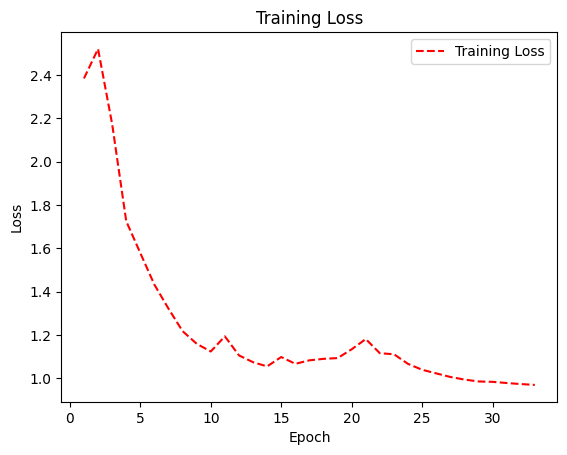

In [21]:
# Get training and test loss histories
training_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss)+1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
# plt.plot(epoch_count, val_loss, 'b-')
plt.title('Training Loss')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

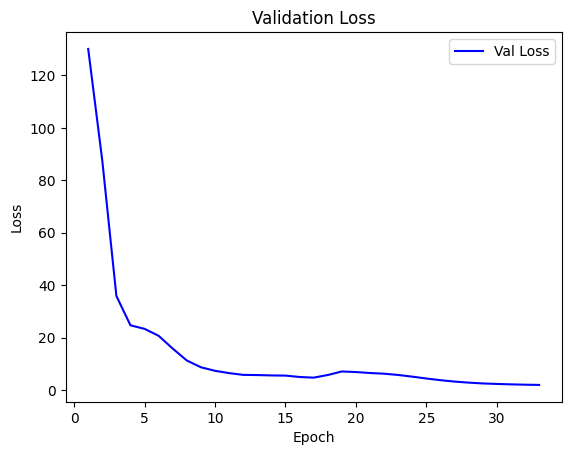

In [22]:
epoch_count = range(1, len(training_loss)+1)

plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Val Loss'])
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

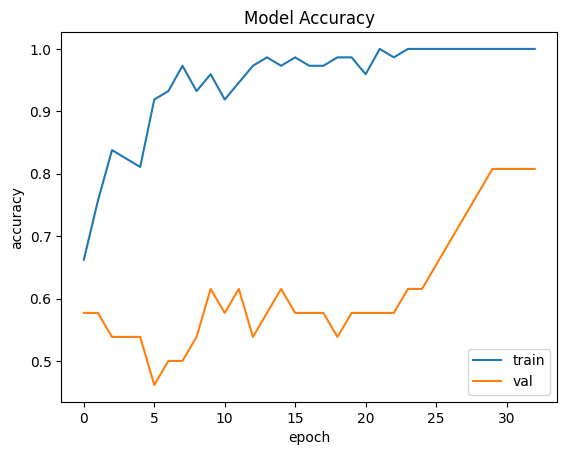

In [23]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

1/1 [==============================] - 1s 705ms/step


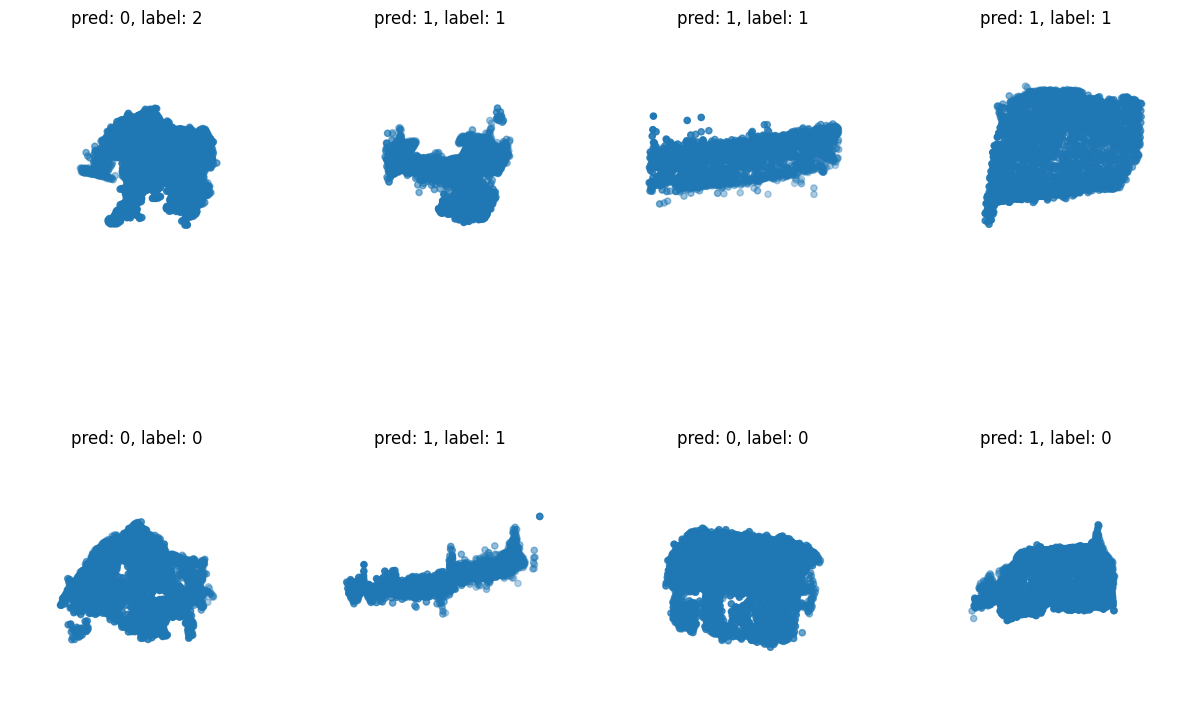

In [24]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = new_model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(preds[i].numpy(),labels.numpy()[i])
    )
    ax.set_axis_off()
plt.show()

In [25]:
dataset = test_dataset
total_count = 0
correct_count = 0
expected = []
predicted = []
accuracy_arr = []

for element in dataset.as_numpy_iterator():
    points = element[0]
    labels = element[1]
    pred = new_model.predict(points)
    pred = tf.math.argmax(pred, -1)
    for index, point in enumerate(points):
        pred = new_model.predict(points)
        pred = tf.math.argmax(pred, -1)
        total_count += 1
        predicted.append(pred[index])
        expected.append(labels[index])
        if labels[index] == pred[index]:
            correct_count += 1
        
        accuracy  = correct_count / total_count
        print("Accuracy  is {}".format(accuracy))
        accuracy_arr.append(accuracy)
            
accuracy  = correct_count / total_count
print("Accuracy  is {}".format(accuracy))

1/1 [==============================] - 0s 438ms/step
Accuracy  is 0.0
1/1 [==============================] - 0s 459ms/step
Accuracy  is 0.5
1/1 [==============================] - 0s 418ms/step
Accuracy  is 0.6666666666666666
1/1 [==============================] - 0s 417ms/step
Accuracy  is 0.75
1/1 [==============================] - 0s 422ms/step
Accuracy  is 0.8
1/1 [==============================] - 0s 450ms/step
Accuracy  is 0.8333333333333334
1/1 [==============================] - 0s 481ms/step
Accuracy  is 0.8571428571428571
1/1 [==============================] - 0s 469ms/step
Accuracy  is 0.75
1/1 [==============================] - 0s 395ms/step
Accuracy  is 0.7777777777777778
1/1 [==============================] - 0s 383ms/step
Accuracy  is 0.8
1/1 [==============================] - 0s 415ms/step
Accuracy  is 0.8181818181818182
1/1 [==============================] - 0s 406ms/step
Accuracy  is 0.8333333333333334
1/1 [==============================] - 0s 443ms/step
Accuracy  is 0.

In [26]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

In [27]:
label_names = np.array(['building','ground','vegetation'])

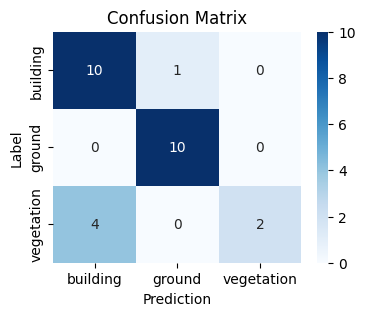

Accuracy: 0.814815
Precision: 0.814815
Recall: 0.814815
F1 score: 0.814815
              precision    recall  f1-score   support

    building       0.71      0.91      0.80        11
      ground       0.91      1.00      0.95        10
  vegetation       1.00      0.33      0.50         6

    accuracy                           0.81        27
   macro avg       0.87      0.75      0.75        27
weighted avg       0.85      0.81      0.79        27



In [28]:
confusion_mtx = tf.math.confusion_matrix(expected, predicted)
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g',cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

accuracy = accuracy_score(expected, predicted)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)  58/(58+6)  : was something else but predicted b,g,v
precision = precision_score(expected, predicted, average='micro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)   58/(58+6)  : was b,g,v but predicted as something else
recall = recall_score(expected, predicted, average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)  2*58/(2*58+6+6)
f1 = f1_score(expected, predicted, average='micro')
print('F1 score: %f' % f1)

print(classification_report(expected, predicted,target_names=label_names))

### Results with early stopping at start epoch 40 and patience 3

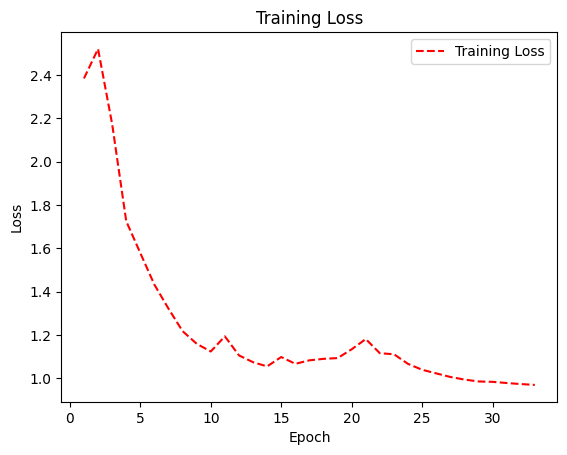

In [29]:
# Get training and test loss histories
training_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss)+1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
# plt.plot(epoch_count, val_loss, 'b-')
plt.title('Training Loss')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

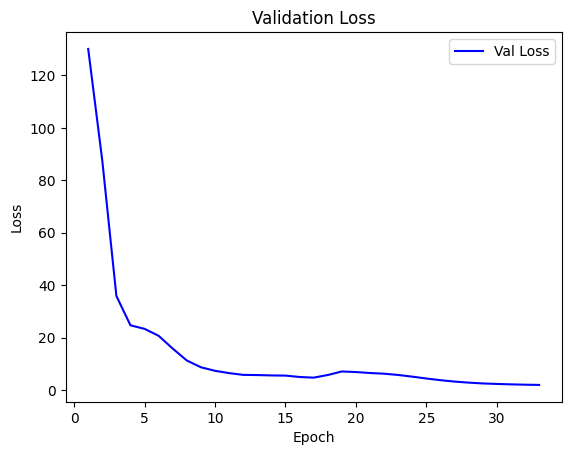

In [30]:
epoch_count = range(1, len(training_loss)+1)

plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Val Loss'])
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

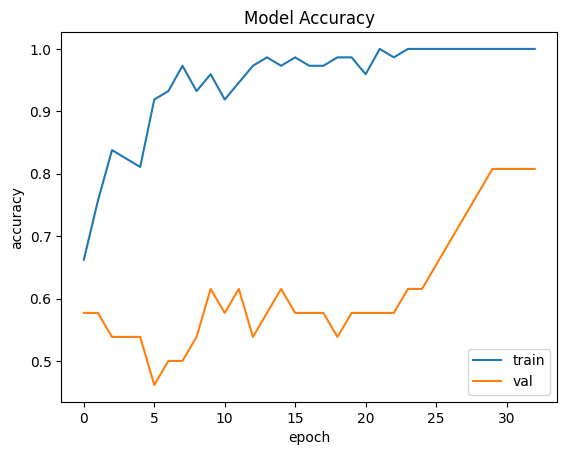

In [31]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

1/1 [==============================] - 0s 183ms/step


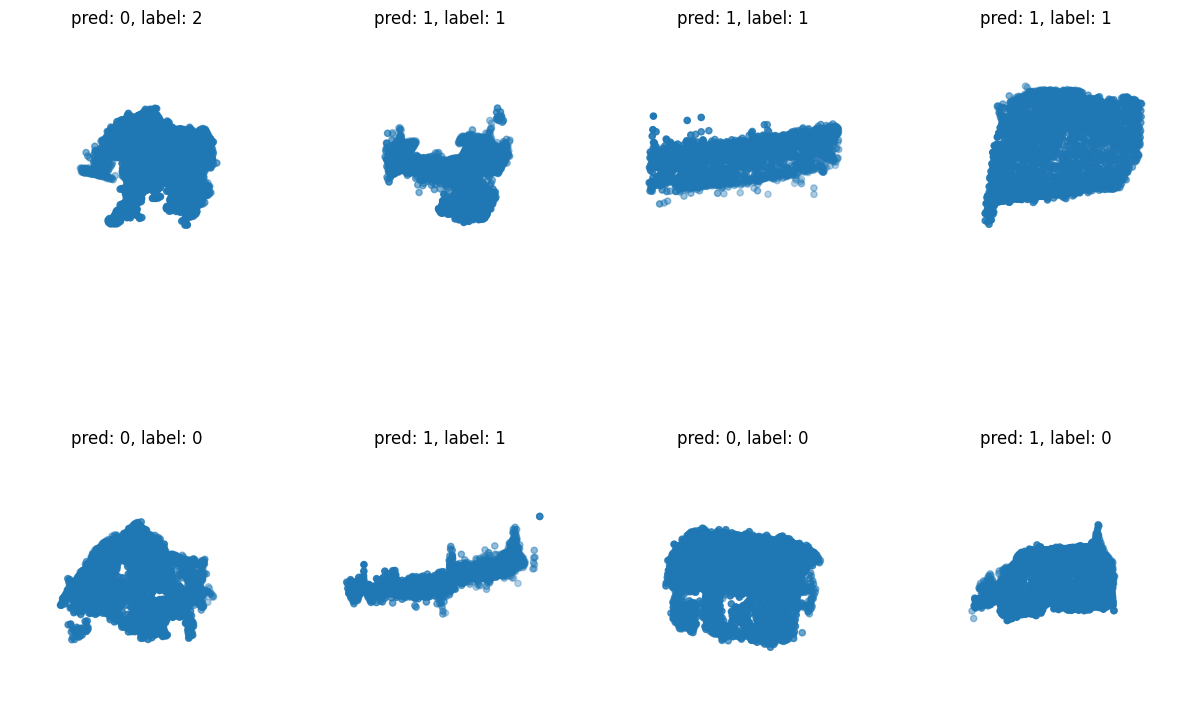

In [32]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = new_model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(preds[i].numpy(),labels.numpy()[i])
    )
    ax.set_axis_off()
plt.show()

In [33]:
dataset = test_dataset
total_count = 0
correct_count = 0
expected = []
predicted = []
accuracy_arr = []

for element in dataset.as_numpy_iterator():
    points = element[0]
    labels = element[1]
    pred = new_model.predict(points)
    pred = tf.math.argmax(pred, -1)
    for index, point in enumerate(points):
        pred = new_model.predict(points)
        pred = tf.math.argmax(pred, -1)
        total_count += 1
        predicted.append(pred[index])
        expected.append(labels[index])
        if labels[index] == pred[index]:
            correct_count += 1
        
        accuracy  = correct_count / total_count
        print("Accuracy  is {}".format(accuracy))
        accuracy_arr.append(accuracy)
            
accuracy  = correct_count / total_count
print("Accuracy  is {}".format(accuracy))

1/1 [==============================] - 0s 407ms/step
Accuracy  is 0.0
1/1 [==============================] - 0s 352ms/step
Accuracy  is 0.5
1/1 [==============================] - 0s 348ms/step
Accuracy  is 0.6666666666666666
1/1 [==============================] - 0s 430ms/step
Accuracy  is 0.75
1/1 [==============================] - 0s 433ms/step
Accuracy  is 0.8
1/1 [==============================] - 0s 375ms/step
Accuracy  is 0.8333333333333334
1/1 [==============================] - 0s 374ms/step
Accuracy  is 0.8571428571428571
1/1 [==============================] - 0s 386ms/step
Accuracy  is 0.75
1/1 [==============================] - 0s 392ms/step
Accuracy  is 0.7777777777777778
1/1 [==============================] - 0s 348ms/step
Accuracy  is 0.8
1/1 [==============================] - 0s 428ms/step
Accuracy  is 0.8181818181818182
1/1 [==============================] - 1s 555ms/step
Accuracy  is 0.8333333333333334
1/1 [==============================] - 0s 441ms/step
Accuracy  is 0.

In [34]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

In [35]:
label_names = np.array(['building','ground','vegetation'])

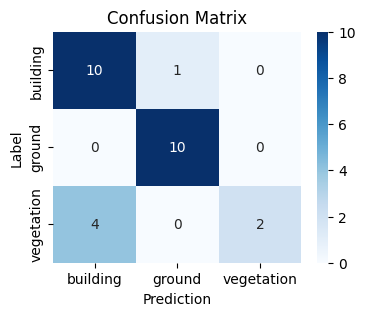

Accuracy: 0.814815
Precision: 0.814815
Recall: 0.814815
F1 score: 0.814815
              precision    recall  f1-score   support

    building       0.71      0.91      0.80        11
      ground       0.91      1.00      0.95        10
  vegetation       1.00      0.33      0.50         6

    accuracy                           0.81        27
   macro avg       0.87      0.75      0.75        27
weighted avg       0.85      0.81      0.79        27



In [36]:
confusion_mtx = tf.math.confusion_matrix(expected, predicted)
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g',cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

accuracy = accuracy_score(expected, predicted)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)  58/(58+6)  : was something else but predicted b,g,v
precision = precision_score(expected, predicted, average='micro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)   58/(58+6)  : was b,g,v but predicted as something else
recall = recall_score(expected, predicted, average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)  2*58/(2*58+6+6)
f1 = f1_score(expected, predicted, average='micro')
print('F1 score: %f' % f1)

print(classification_report(expected, predicted,target_names=label_names))
